In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import itertools
from numba import njit, prange
from sympy import symbols, sqrt, solve, lambdify
from scipy.optimize import minimize, direct
from modules import *

In [3]:
OKABE_ITO = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
PATH = "../paper"

In [4]:
# Creates the CLASP and bound receptor functions for the model
def setup(params):

    # Define parameters and variables
    a, b0, b1, Kd = params
    C, RT, RB, B, P = symbols('C RT RB B P')
            
    # Solve the system at quasi-steady state
    system = [
        b0 - b1 * RB - C,
        62 * (0.65 + 0.35 * C) - RT,
        (1/2) * ((B + RT + Kd) - sqrt((B + RT + Kd)**2 - 4 * RT * B)) - RB,
        a + ((1 - a) * P / 1000) - B
    ]

    # Compute the steady states, then return only the CLASP and RB functions
    steady_states = solve(system, [C, RT, RB, B], dict = True)[-1]
    return [njit(lambdify(P, steady_states[C])), njit(lambdify(P, steady_states[RB]))]

In [5]:
# Define the hyperparameter sets for each mutant
# Currently susing LINEAR model
WT_PARAMS = (0.001, 1.389, 0.895, 8.901)
BC_PARAMS = (0.001, 1.389, 0.000, 8.901)
C1_PARAMS  =(0.001, 0.000, 0.000, 8.901)

# Define additional configuration information for the simulation
STEP = 0.002
MAX_CELLS = 5000
MAX_TIME = 15
MAX_SIZE = 150
MAX_POSITION = 500
NBINS = 20
VT = np.arange(0, MAX_TIME + STEP, STEP) 

In [6]:
# Compute the binned averages of a dataset
@njit
def bin_data(data):
    positions, lengths = data[:, 0], data[:, 1]   
    indices = np.digitize(positions, np.linspace(0, MAX_POSITION, NBINS + 1))
    means, errors = np.empty(NBINS), np.empty(NBINS)
    for i in range(NBINS):
        
        group = lengths[indices == i + 1]

        # Send an error code if a bin is empty
        if group.size == 0: 
            return np.zeros(NBINS), np.zeros(NBINS)
            
        means[i] = np.mean(group)
        errors[i] = np.std(group) / np.sqrt(group.size)

    return means, errors

# Process the experimental data by getting the binned averages
def process_experimental_data(prefix):
    data, fit, se = get_mutant_data("trichoblast", prefix, 10, 12)
    return bin_data(data)

In [7]:
@njit
def simulate_step(params, fRB, fC, L, P, D, i):

    # Unpack the parameters, create lambda functions
    n = 10
    m, g0, g1, d0, d1 = params
    dL = lambda l, p: ((g0 + g1 * fRB(p)) * l) * STEP
    dD = lambda l, p: (1 + d0 * fC(p)) * (1 - ((l ** n) / ((d1 ** n) + (l ** n)))) * STEP
    
    # Unpack the data from the previous and current row
    L0, P0, D0 = L[i-1, :], P[i-1, :], D[i-1, :]
    L1, D1 = L[i, :], D[i, :]

    # Iterate through the (i-1)-th row and update
    j, k = 0, 0
    while L0[j] > 0:

        # Handle the division case, but only if D1 is not full
        if D0[j] >= 1 and L0[j] > m and k + 1 < MAX_CELLS:
            D1[k], D1[k+1] = 0, 0
            L1[k], L1[k+1] = L0[j]/2, L0[j]/2
            k += 1

        # Handle the growth case
        elif L0[j] < MAX_SIZE:
            D1[k] = D0[j] + dD(L0[j], P0[j])
            L1[k] = L0[j] + dL(L0[j], P0[j])

        # Handle the differentiation case
        else:
            D1[k] = D0[j]
            L1[k] = L0[j]
        
        k += 1
        j += 1

    # Update the position vector and return
    return L1, np.cumsum(L1), D1

# Process data from a simulation, compute error of model means from experimental means
@njit
def analyze_simulation(data):

    # Unpack the data from the simulation, filter the data to remove points before t = 5
    (L, P, D) = data
    L = L[int(5 / STEP):]
    P = P[int(5 / STEP):]

    # Then sample one point from every 100 time steps
    size = L.shape[0]
    L = L[np.arange(size) % 100 == 0, :]
    P = P[np.arange(size) % 100 == 0, :]

    # Flatten the L and P arrays
    L = L.flatten()
    P = P.flatten()

    # Create a new data array containing only nonzero lengths, then filter positions above 500um
    tups = np.stack((P, L), axis = 1)
    tups = tups[(tups[:, 1] > 4) & (tups[:, 1] < MAX_SIZE) & (tups[:, 0] < 500)]

    # Return the binned data
    return bin_data(tups)

In [8]:
@njit
def simulate_root(params, fRB, fC, vT, max_cells, observed):

    # Create arrays for cell lengths, positions, and division statuses
    L = np.zeros((vT.size, max_cells)) 
    P = np.zeros((vT.size, max_cells)) 
    D = np.zeros((vT.size, max_cells)) 

    # Set the initial lengths and positions
    L[0, :10] = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
    P[0, :] = np.cumsum(L[0, :])

    # Run the simulation loop
    for i in np.arange(1, vT.size):
        L[i, :], P[i, :], D[i, :] = simulate_step(params, fRB, fC, L, P, D, i)

    # Simplify the predictions by running analyze_simulation, then check for failed simulations
    predicted, se = analyze_simulation((L, P, D))
    if (predicted == np.zeros(NBINS)).all():
        return (L, P, D), predicted, 1000

    # Compute the rmse and return
    rmse = np.sqrt((1 / observed.size) * np.sum((predicted - observed) ** 2))
    return (L, P, D), predicted, rmse

# Run a simulation of all three mutants given a set of parameters
@njit
def simulate_mutants(params, fWTRB, fWTC, fBCRB, fBCC, fC1RB, fC1C, datasets):

    # Unpack the datasets array
    wt_data, bc_data, c1_data = datasets

    # Simulate each of the mutants individually and compute their error from observations
    wt_raw, wt_model, wt_rmse = simulate_root(params, fWTC, fWTRB, VT, MAX_CELLS, wt_data)
    bc_raw, bc_model, bc_rmse = simulate_root(params, fBCC, fBCRB, VT, MAX_CELLS, bc_data)
    c1_raw, c1_model, c1_rmse = simulate_root(params, fC1C, fC1RB, VT, MAX_CELLS, c1_data)

    # Compute the rmse and package up the model results
    rmse = wt_rmse + bc_rmse + c1_rmse
    raws = (wt_raw, bc_raw, c1_raw)
    models = (wt_model, bc_model, c1_model)

    print(params)
    print(rmse)
    return raws, models, rmse

In [9]:
# Unpack the setup tuples to get the intracellular functions
fWTRB, fWTC = setup(WT_PARAMS)
fBCRB, fBCC = setup(BC_PARAMS)
fC1RB, fC1C = setup(C1_PARAMS)

# Get the fit for the experimental data
vP = np.linspace(0, 1000, 1001)
wt_data, wt_se = process_experimental_data("WT-")
bc_data, bc_se = process_experimental_data("BC-")
c1_data, c1_se = process_experimental_data("C1-")
DATASETS = [wt_data, bc_data, c1_data]
ERRORS = [wt_se, bc_se, c1_se]

In [10]:
def fit_model():

    # Set parameter bounds
    bounds = [(5, 15), (0, 1), (0, 10), (0, 1), (15, 25)]
    cost = lambda params : simulate_mutants(params, fWTRB, fWTC, fBCRB, fBCC, fC1RB, fC1C, DATASETS)[-1]

    # Find the parameters of best fit
    fit = direct(
        func = cost, 
        bounds = bounds
    )

    # Run a simulation with the optimal parameters
    raws, models, rmse = simulate_mutants(fit.x, fWTRB, fWTC, fBCRB, fBCC, fC1RB, fC1C, DATASETS)
    m, g0, g1, d0, d1 = fit.x

    # Log the simulation
    print("Success: ", fit.success, fit.message)
    print(f"Params: {m:.3e}, {g0:.3e}, {g1:.3e}, {d0:.3e}, {d1:.3e}")
    print("Error: ", rmse)
        
    return raws, models, rmse, fit.x

In [11]:
raws, models, rmse, optimal = fit_model()

[10.   0.5  5.   0.5 20. ]
32.60815694250141
[13.33333333  0.5         5.          0.5        20.        ]
16.733480460050444
[ 6.66666667  0.5         5.          0.5        20.        ]
44.734987147713824
[10.          0.83333333  5.          0.5        20.        ]
1015.4544361293953
[10.          0.16666667  5.          0.5        20.        ]
42.46671791535214
[10.          0.5         8.33333333  0.5        20.        ]
22.109791847754856
[10.          0.5         1.66666667  0.5        20.        ]
49.15404631587503
[10.          0.5         5.          0.83333333 20.        ]
35.28054089622188
[10.          0.5         5.          0.16666667 20.        ]
23.27790700256419
[10.          0.5         5.          0.5        23.33333333]
33.90371005459186
[10.          0.5         5.          0.5        16.66666667]
29.49576635244633
[13.33333333  0.83333333  5.          0.5        20.        ]
1009.2418138636253
[13.33333333  0.16666667  5.          0.5        20.        ]
32.51254

In [12]:
plt.rcParams['figure.dpi'] = 360
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (10, 8)

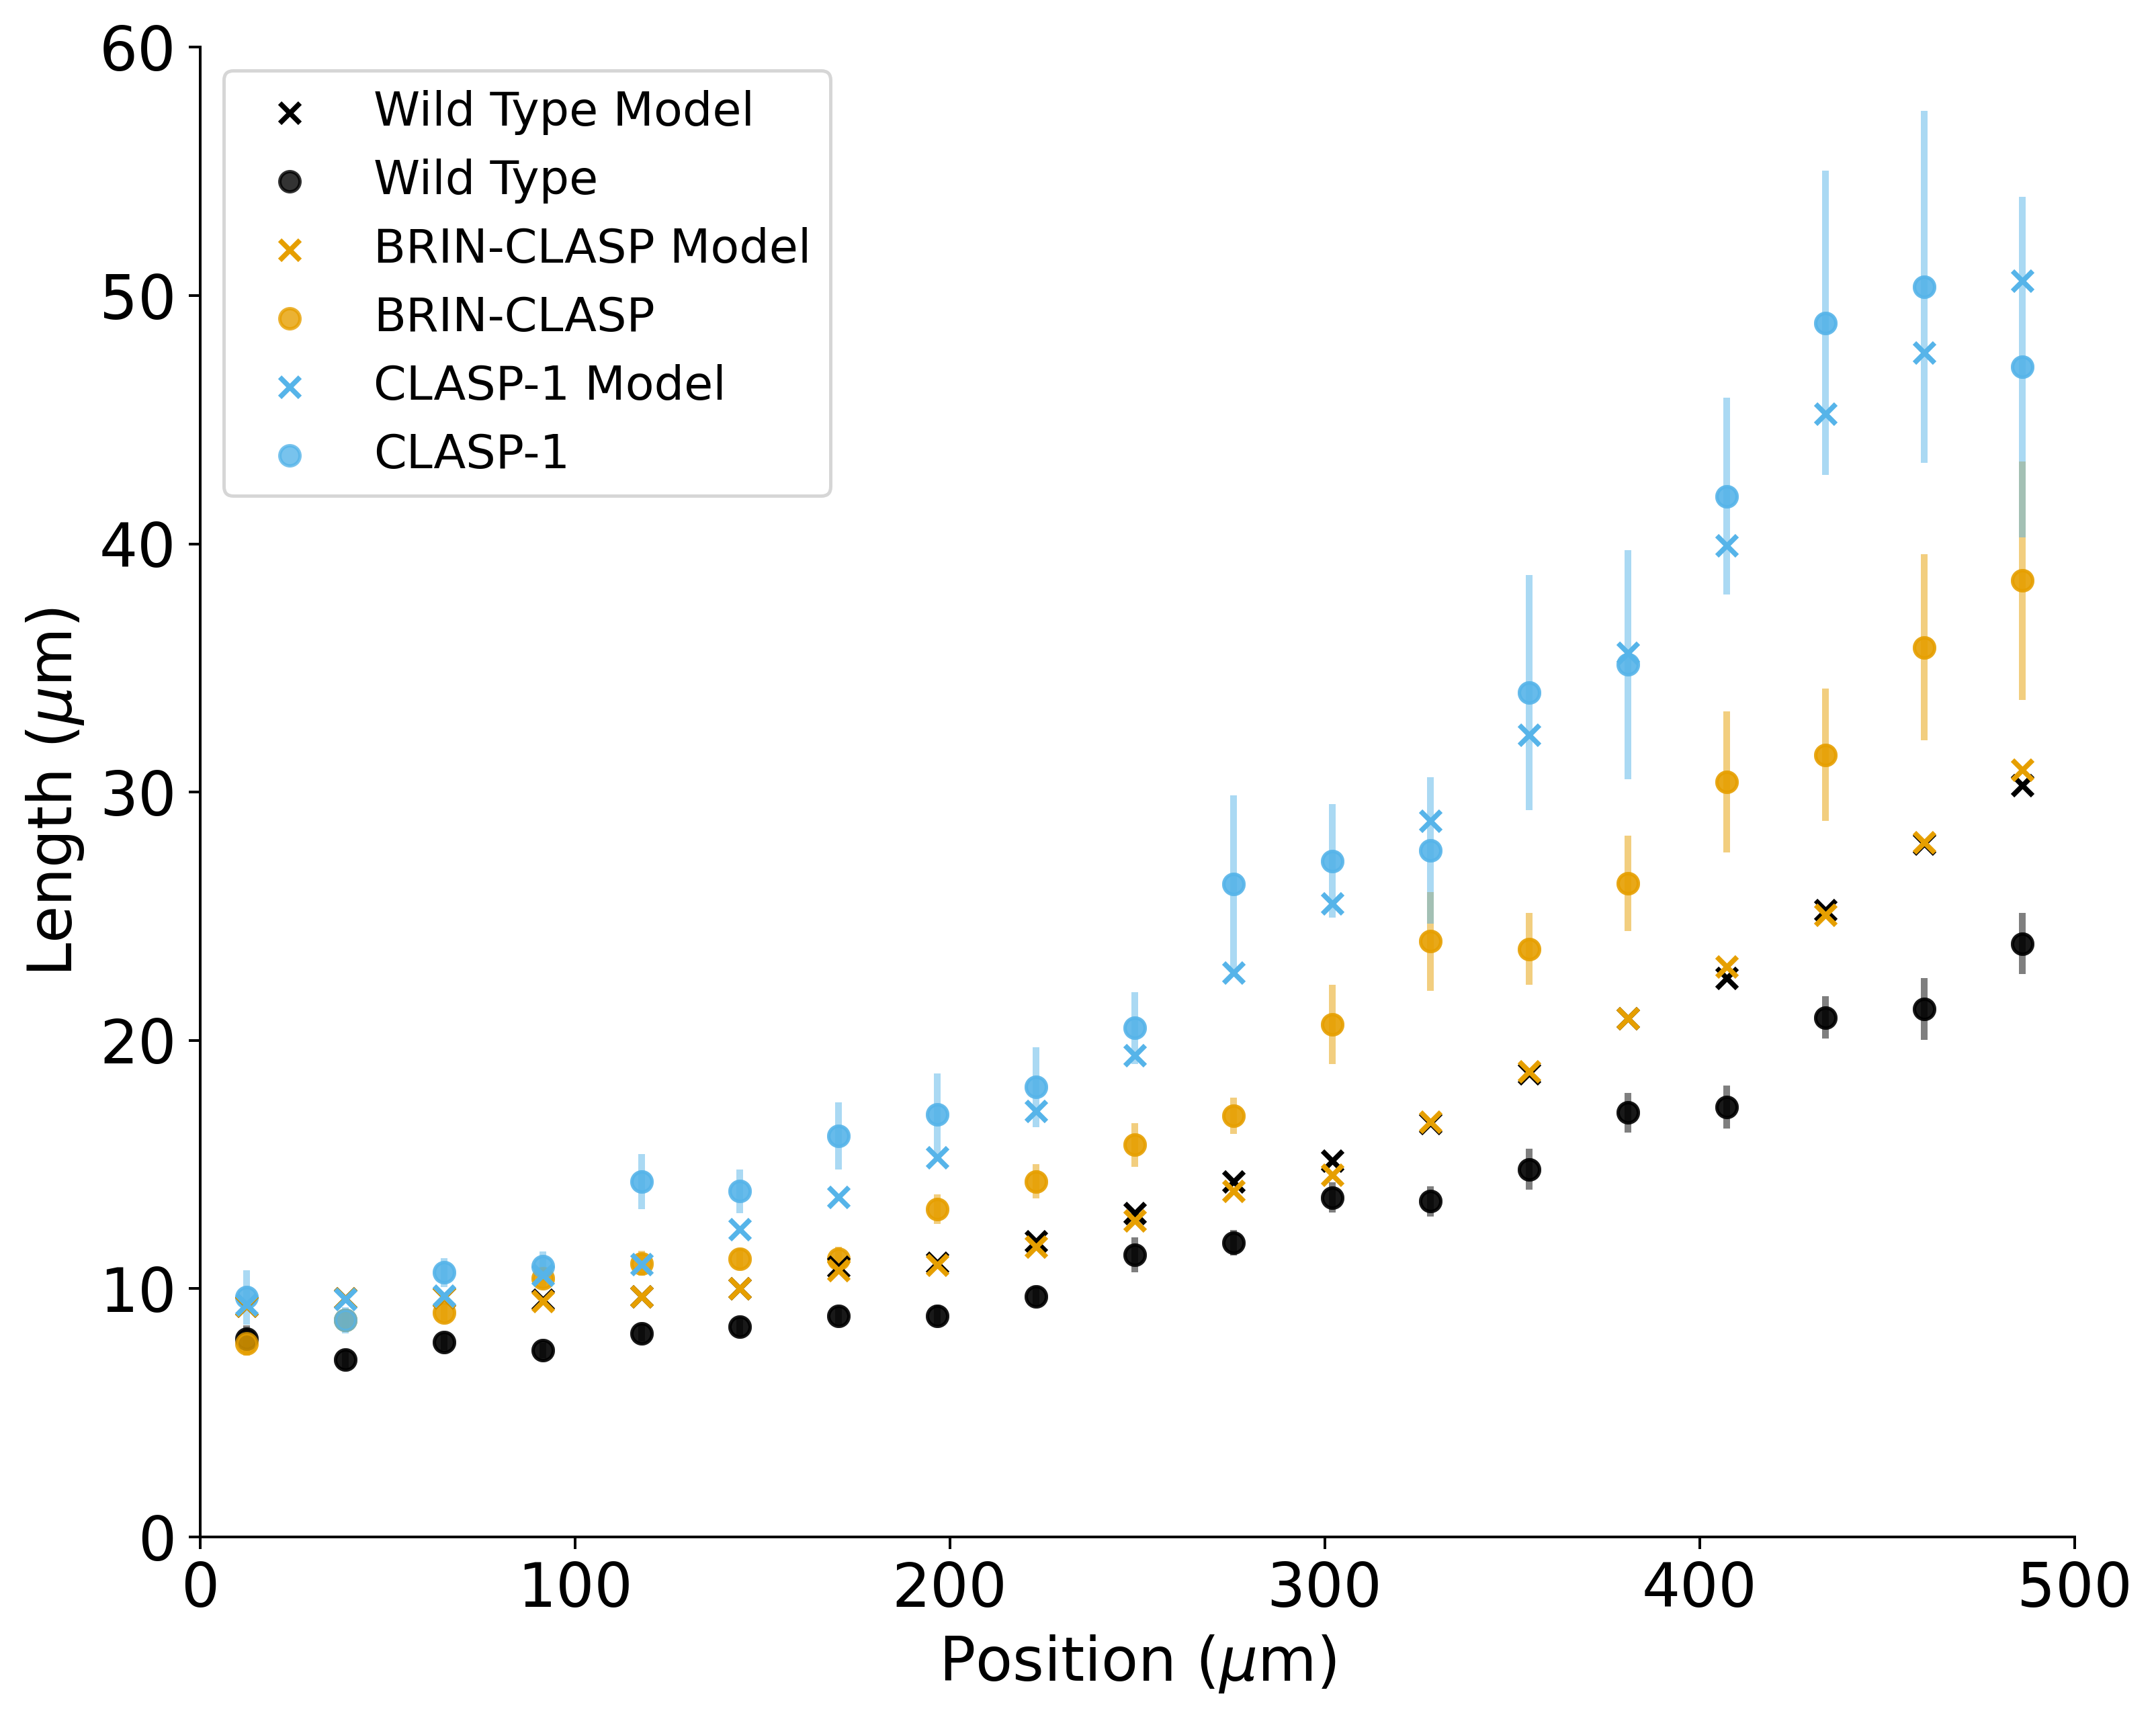

In [13]:
def plot_position_length(models):

    vP = np.linspace(0, 1000, 1001)

    # Create a scatterplot
    ax = plt.subplot(111)
    ax.set_xlabel(r"Position ($\mu$m)")
    ax.set_ylabel(r"Length ($\mu$m)")
    ax.set_xlim((0, 500))
    ax.set_ylim((0, 60))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Helper function to plot the model results for a mutant
    def plot_mutant(model, data, se, label, color):

        mid, step = MAX_POSITION / (2 * NBINS), MAX_POSITION / NBINS
        ps = np.linspace(mid, (step * NBINS) + mid, NBINS)

        # Plot the model results
        plt.scatter(ps, model, alpha = 1, zorder = 4, marker = "x", color = color, label = f"{label} Model")

        # Plot the experimental results
        plt.scatter(ps, data, alpha = 0.8, zorder = 3, color = color, label = label)
        plt.errorbar(ps, data, yerr = se, color = color, fmt = "o", lw = 2, alpha = 0.5)

    labels = ["Wild Type", "BRIN-CLASP", "CLASP-1"]
    colors = OKABE_ITO[:3]
    
    for m, d, e, l, c in zip(models, DATASETS, ERRORS, labels, colors):
        plot_mutant(m, d, e, l, c)

    plt.legend(prop = {'size': 14})
    plt.savefig(f"{PATH}/column-position-length.pdf", format = 'pdf')

plot_position_length(models)

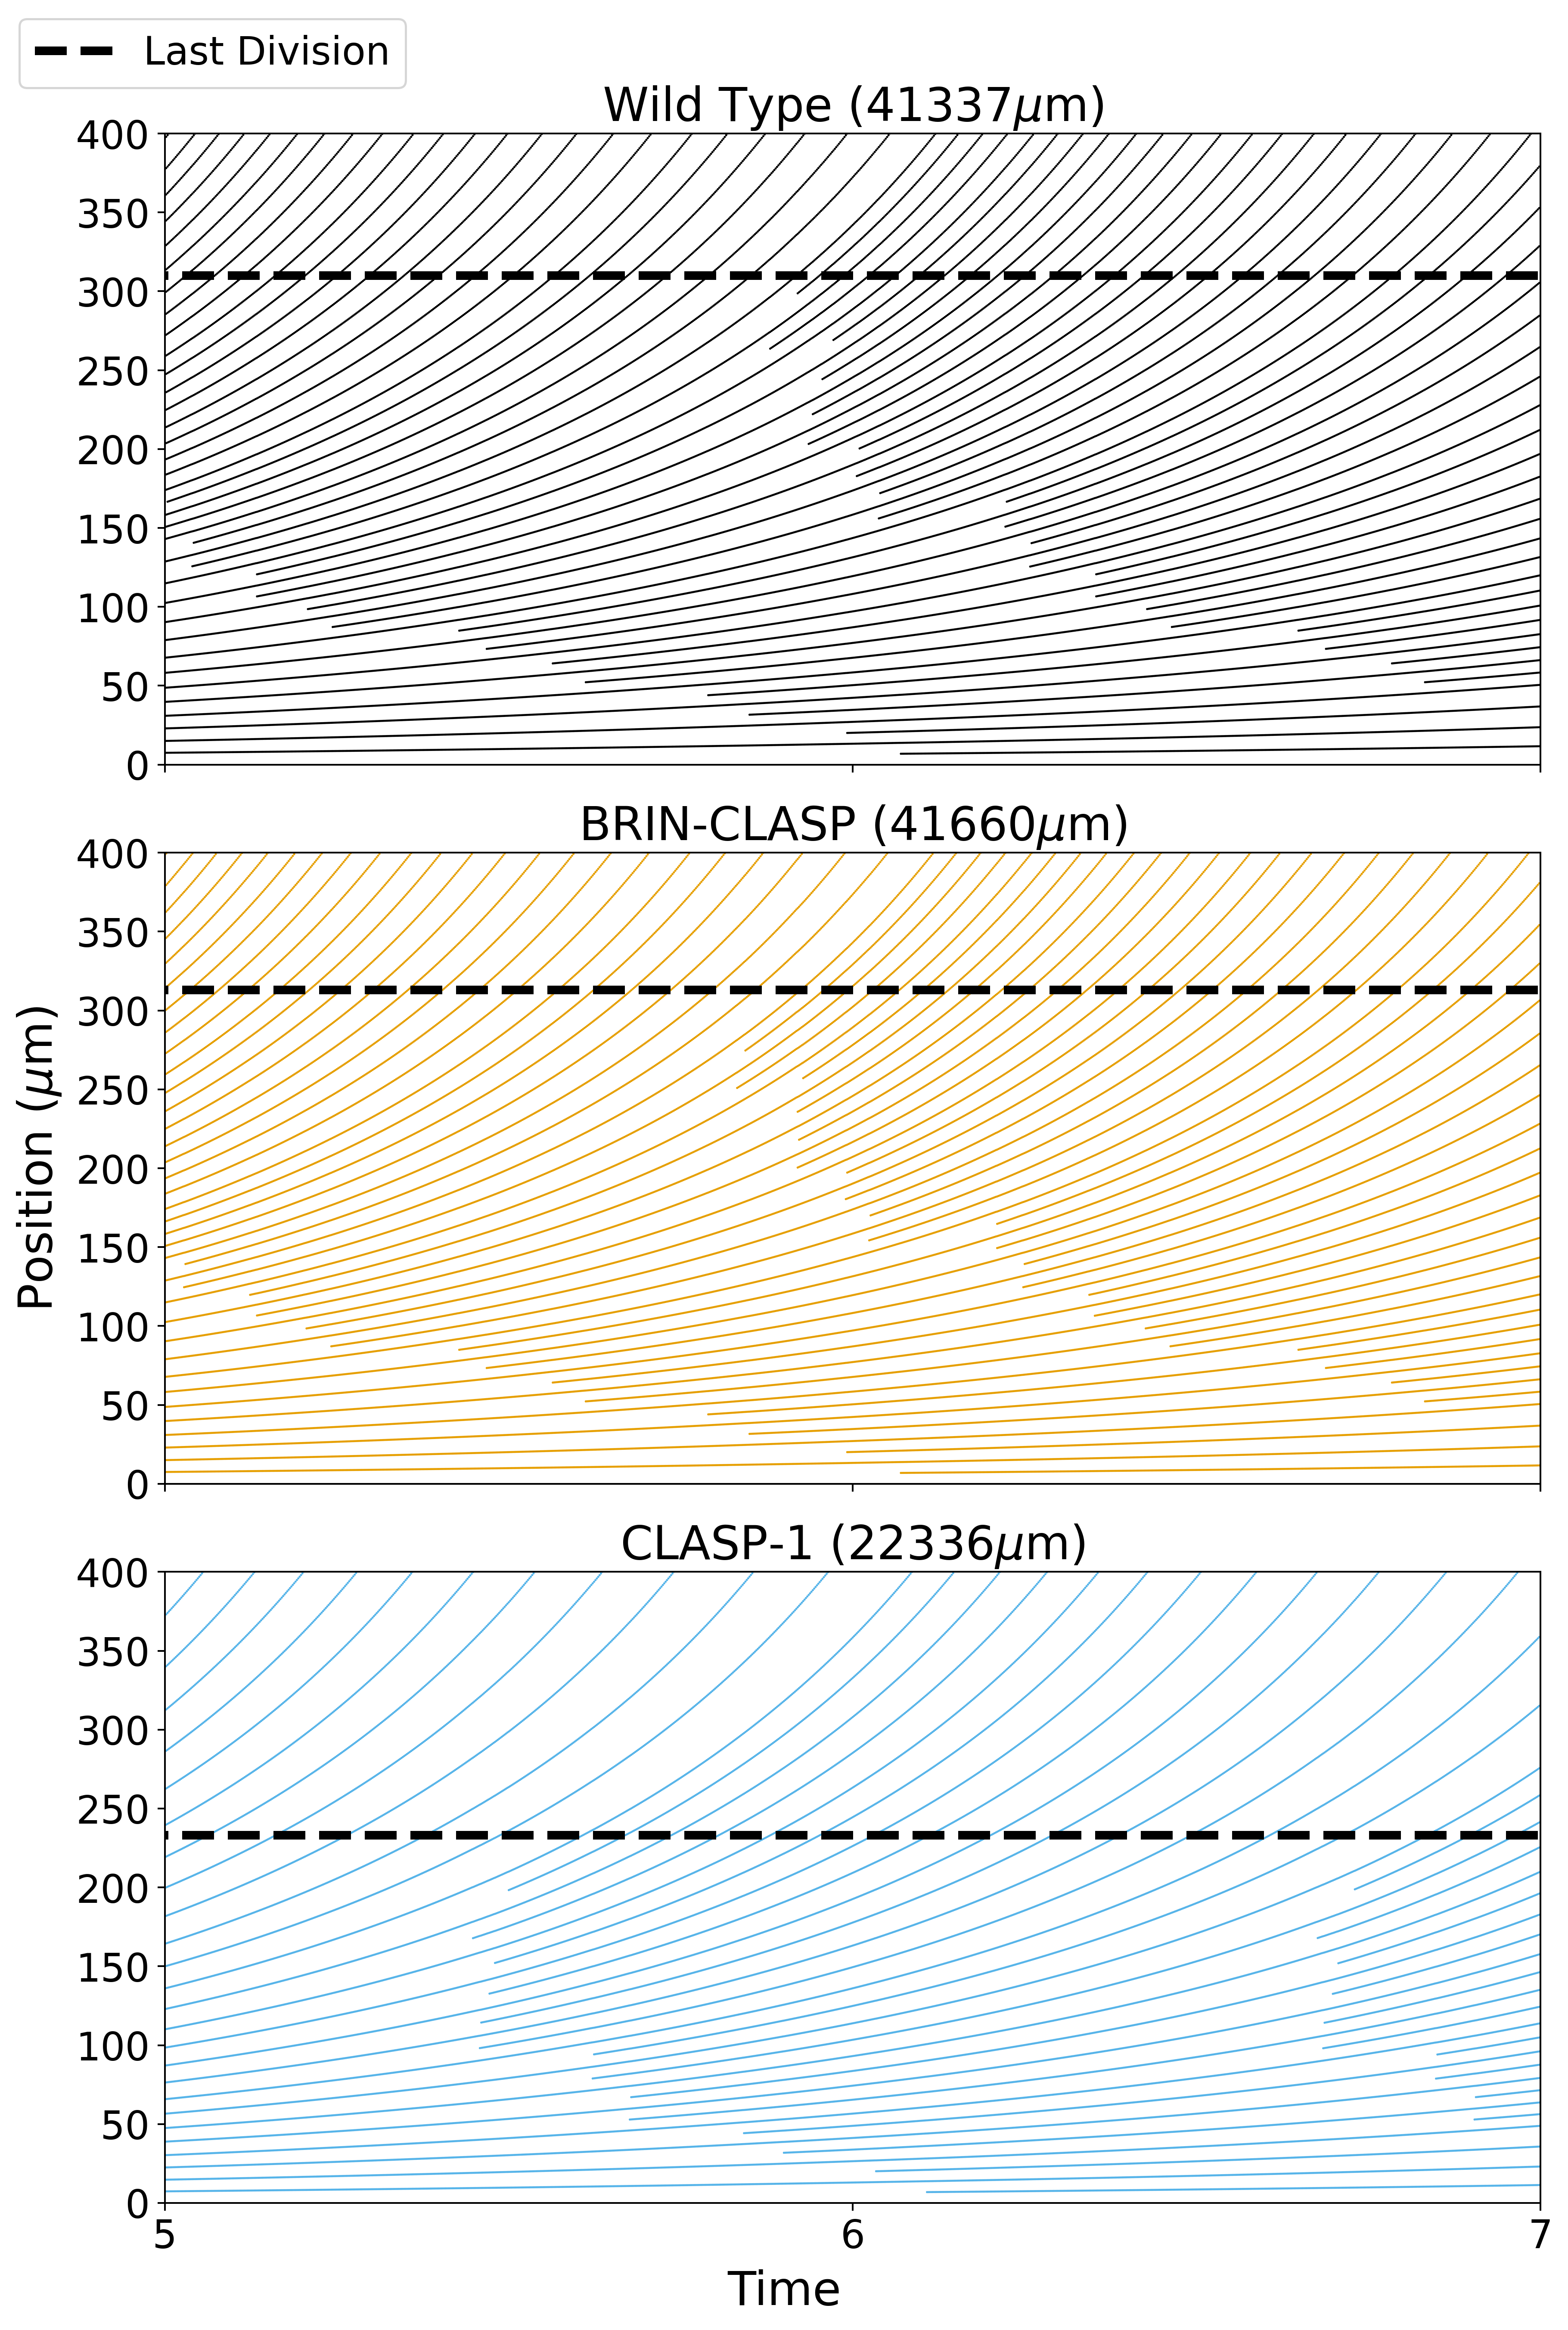

In [16]:
def find_last_division(data):
    L, P, D = data
    divisions = P[np.where(D > 1)]
    return np.max(divisions), np.max(P)

# Filter the data
def filter_raw_data(data):

    # Only incldue times between 5 and 7
    L, P, D = data
    T = np.tile(np.arange(5, 7, STEP), (MAX_CELLS, 1))
    P = P[int(5 / STEP):int(7 / STEP)]

    # Remove cells above 500um
    tups = np.stack((T.T, P), axis = 2).reshape(-1, 2)
    tups = tups[tups[:, 1] < 500]
    return tups
    
def plot_division_zone(raws):
    
    WT, BC, C1 = raws
    
    wt_last, wt_max = find_last_division(WT)
    bc_last, bc_max = find_last_division(BC)
    c1_last, c1_max = find_last_division(C1)
    
    WT = filter_raw_data(WT)
    BC = filter_raw_data(BC)
    C1 = filter_raw_data(C1)

    mpl.rcParams['figure.figsize'] = (10, 15)
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, sharex = True, layout = "constrained")
    ax1.set_xlim((5, 7))
    ax1.set_xticks([5, 6, 7])
    
    ax1.set_title(rf"Wild Type ({wt_max:.0f}$\mu$m)")
    ax1.scatter(WT[:, 0], WT[:, 1], color = OKABE_ITO[0], s = 1, edgecolor = "none")
    ax1.set_ylim((0, 400))
    wt_div = ax1.hlines(wt_last, 0, MAX_TIME, colors = OKABE_ITO[0], linestyles = "dashed", lw = 4)

    ax2.set_title(rf"BRIN-CLASP ({bc_max:.0f}$\mu$m)")
    ax2.scatter(BC[:, 0], BC[:, 1], color = OKABE_ITO[1], s = 1, edgecolor = "none")
    ax2.set_ylim((0, 400))
    bc_div = ax2.hlines(bc_last, 0, MAX_TIME, colors = OKABE_ITO[0], linestyles = "dashed", lw = 4)

    ax3.set_title(rf"CLASP-1 ({c1_max:.0f}$\mu$m)")
    ax3.scatter(C1[:, 0], C1[:, 1], color = OKABE_ITO[2], s = 1, edgecolor = "none")     
    ax3.set_ylim((0, 400))
    c1_div = ax3.hlines(c1_last, 0, MAX_TIME, colors = OKABE_ITO[0], linestyles = "dashed", lw = 4)

    fig.legend([wt_div], ["Last Division"], loc='outside upper left')
    fig.supxlabel(r"Time")
    fig.supylabel(r"Position ($\mu$m)")
    fig.savefig(f"{PATH}/column-division-zone.pdf", format = 'pdf')


plot_division_zone(raws)

143.44001547895402 132.60288382467587 309.91199792167714 304
141.49516238719755 131.63282732341767 313.09984641274906 306
96.3654086594415 86.24211080211624 233.08833116341265 162


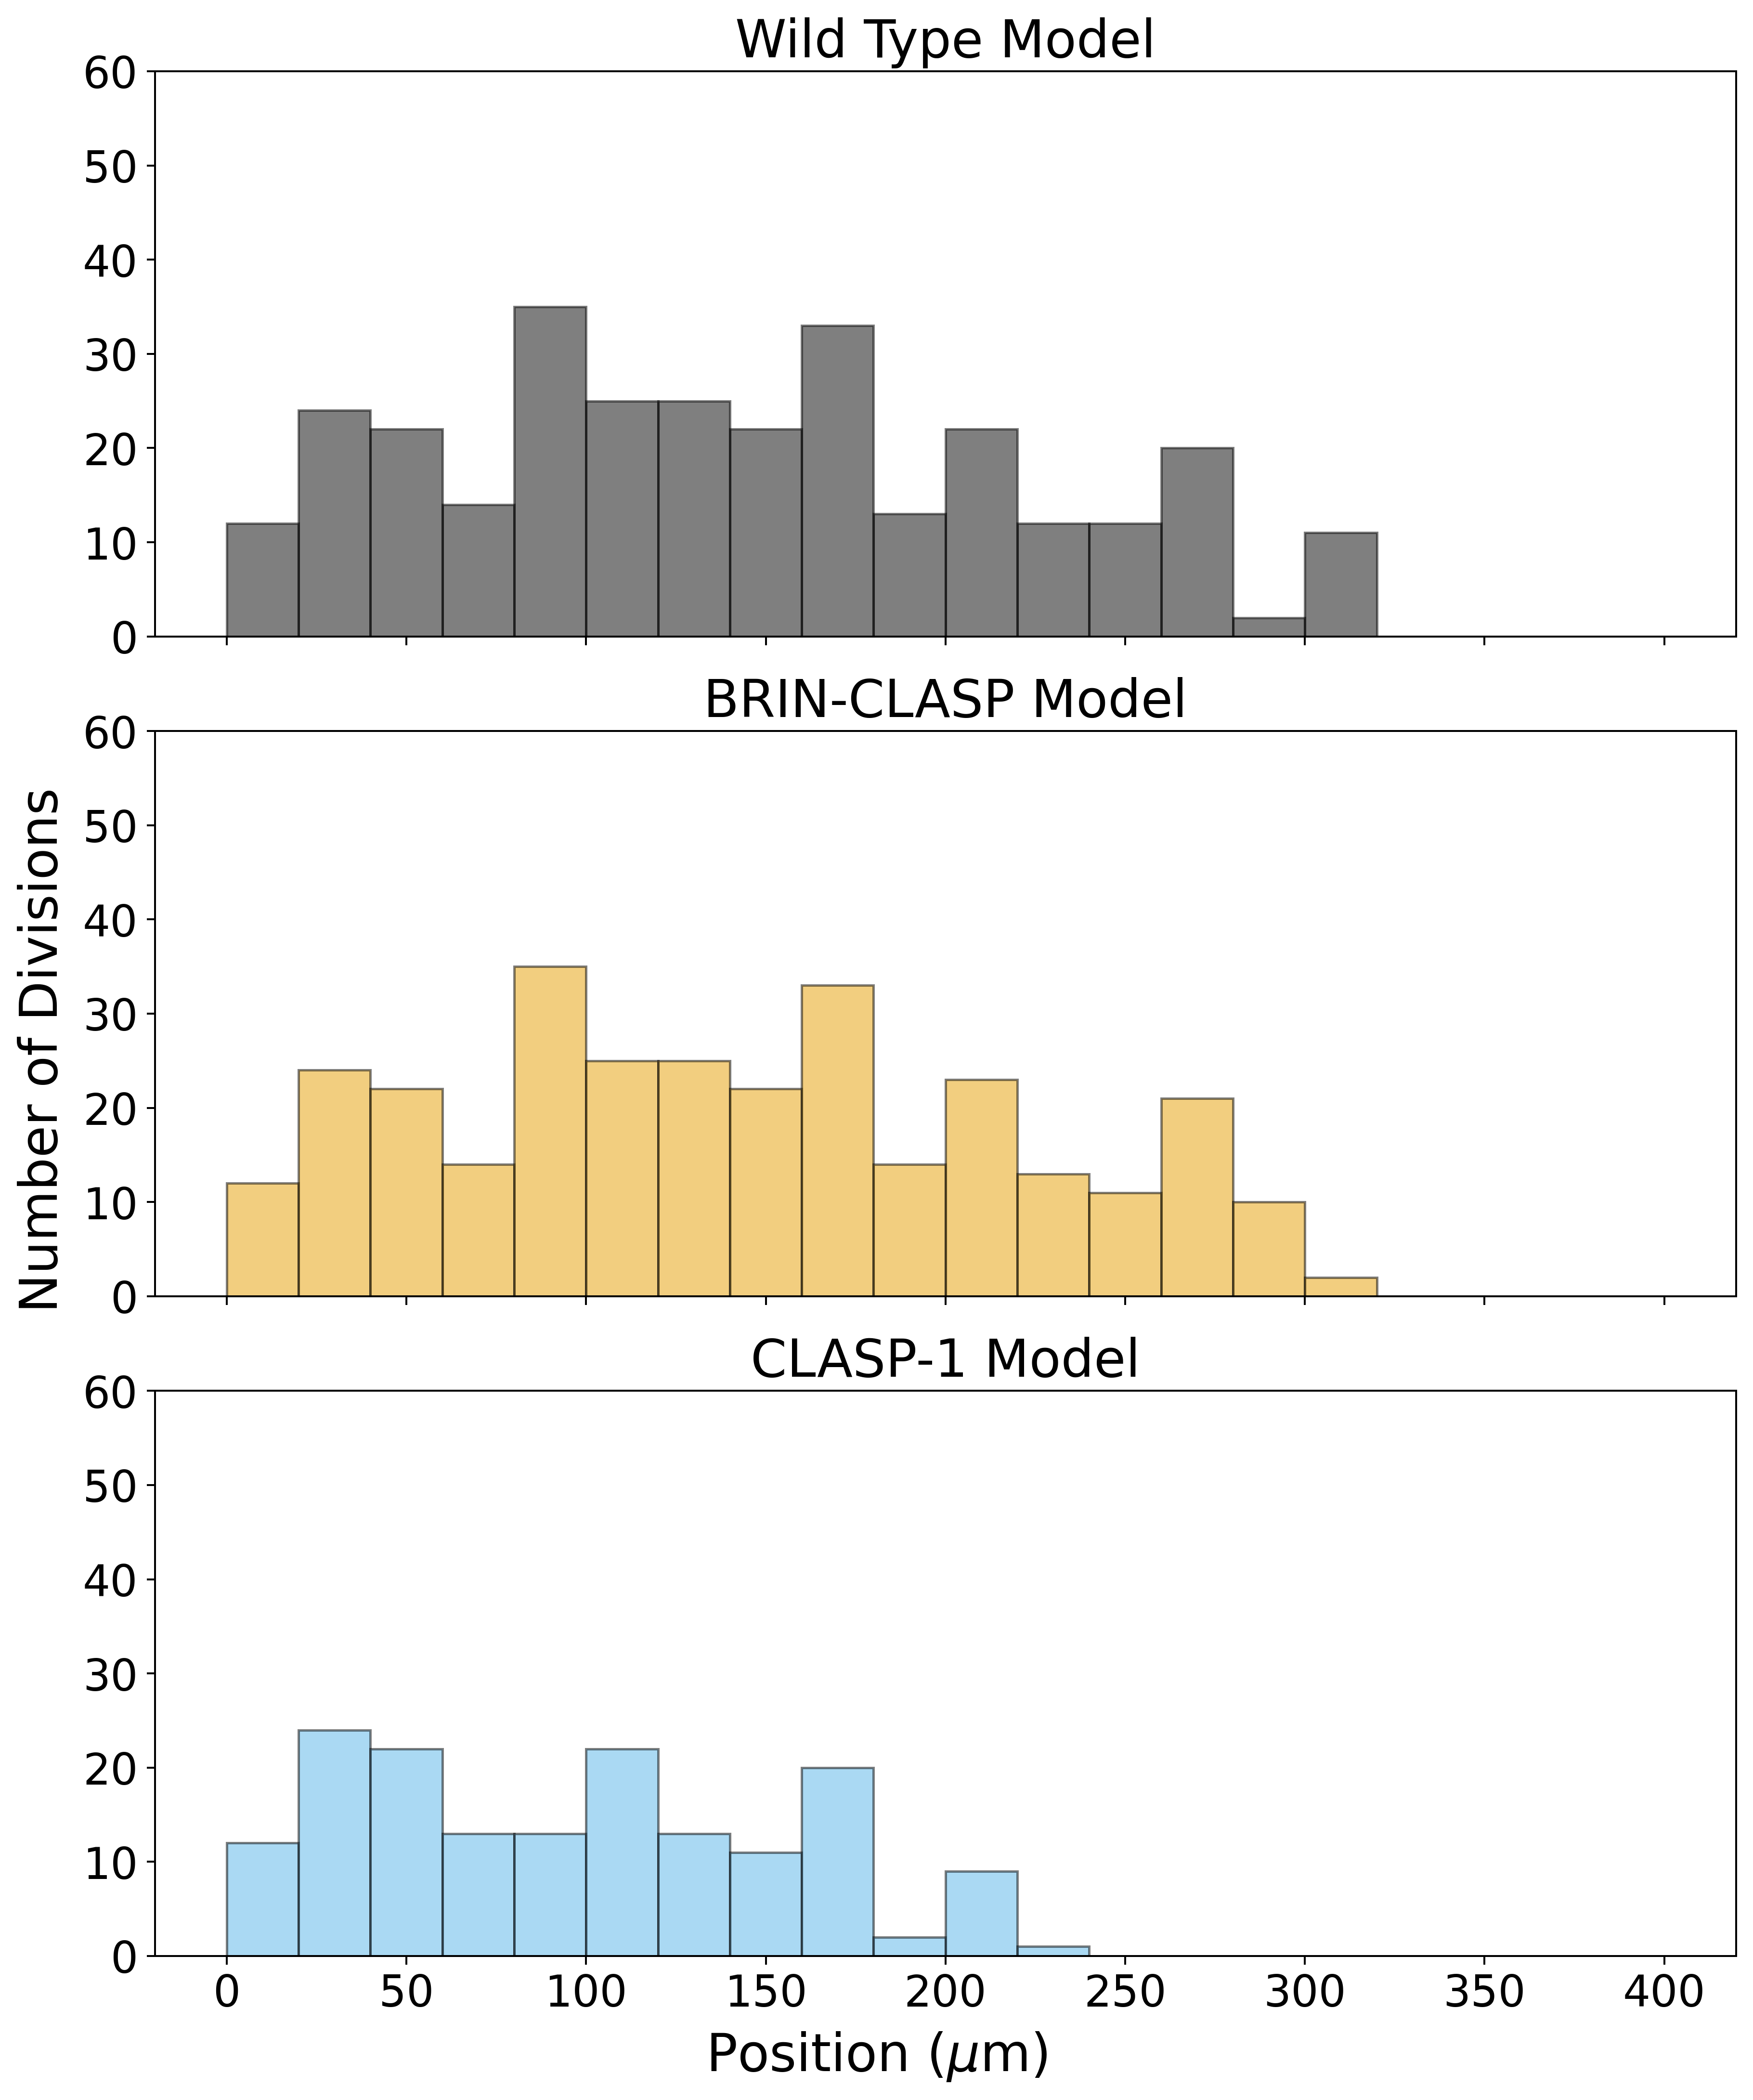

In [17]:
def get_divisions(data):
    L, P, D = data
    return P[np.where((D > 1) & (L > optimal[0]))]

def plot_division_locations(raws):
    WT, BC, C1 = raws
    mpl.rcParams['figure.figsize'] = (10, 12)
    
    wt_divs = get_divisions(WT)
    bc_divs = get_divisions(BC)
    c1_divs = get_divisions(C1)

    print(np.mean(wt_divs), np.median(wt_divs), np.max(wt_divs), np.size(wt_divs))
    print(np.mean(bc_divs), np.median(bc_divs), np.max(bc_divs), np.size(bc_divs))
    print(np.mean(c1_divs), np.median(c1_divs), np.max(c1_divs), np.size(c1_divs))

    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, sharex = True, layout = "constrained")
    fig.supxlabel(r"Position ($\mu$m)")
    fig.supylabel("Number of Divisions")
    
    ax1.set_ylim((0, 60))
    ax2.set_ylim((0, 60))
    ax3.set_ylim((0, 60))
    
    ax1.hist(wt_divs, bins = 20, range=(0, 400), color = OKABE_ITO[0], alpha = 0.5, edgecolor = "k")
    ax2.hist(bc_divs, bins = 20, range=(0, 400), color = OKABE_ITO[1], alpha = 0.5, edgecolor = "k")
    ax3.hist(c1_divs, bins = 20, range=(0, 400), color = OKABE_ITO[2], alpha = 0.5, edgecolor = "k")

    ax1.set_title("Wild Type Model")
    ax2.set_title("BRIN-CLASP Model")
    ax3.set_title("CLASP-1 Model")

    fig.savefig(f"{PATH}/column-division-histogram.pdf", format = 'pdf')

plot_division_locations(raws)